# Визуализация данных
## Peer Review

Визуализация данных - первый шаг в решении практически любой задачи анализа данных, в частности, при участии в соревновании. Визуализация помогает решить, какую предобработку данных нужно провести, какие методы лучше использовать для предсказания, какие признаки добавить. В этом Peer Review мы будем работать с данными [kaggle-соревнования](https://www.kaggle.com/c/prudential-life-insurance-assessment), завершившегося зимой 2016 года. 

__Задача соревнования:__ по характеристикам человека и его заявки на медицинскую страховку предсказать степень риска, характерную для данной страховки.

__Чем будем заниматься мы:__
* рассматривать данные;
* пробовать разные методы визуализации;
* анализировать графики и пытаться сделать выводы, полезные для следующих этапов решения задачи.

Целевой признак (степень риска) в задаче номинальный: целые числа от 1 до 8, а метрика качества, предложенная организаторами соревнования, оценивает степень согласованности двух рейтингов. Поэтому задачу можно решать и методами классификации, и методами регрессии (в последнем случае придется округлять предсказания). Это стоит учитывать при анализе результатов визуализации.

Мы будем визуализировать только обучающую выборку. Часто при решении конкурсов полезно визуализировать также тестовую выборку (на которой нужно сделать предсказание), чтобы убедиться, что данные идентичны.

Часть кода, необходимого для построения графиков, уже написана; для другой части даны инструкции, по которым вам нужно написать скрипт; такие ячейки помечены # Код X, X - число. Кроме того, вам необходимо проанализировать графики, ответив на вопросы.

<font color="red"> Внимание! </font> Мы будем заниматься именно визуализацией - построение изображением. Пожалуйста, отвечайте на вопросы именно __по изображениям__. Если вы считаете, что картинка слишком маленькая, и пытаетесь найти ответ на вопрос другими способами, сопоставляйте его с изображением, потому что в рекомендациях к проверке именно такие ответы. Если вы считаете, что вопрос не корректен, пишите об этом в _специальном_ треде __"Peer Review по визуализации: формулировки вопросов."__ на форуме. Если вы (после проверки других работ) считаете, что рекомендация к проверке не корректна, пишите об этом __в обратной связи к заданию__. 

Визуализацию в python часто делают с помощью библиотеки seaborn. Установить ее можно командой pip install seaborn. Если вы по каким-то причинам не можете установить библиотеку, вам придется строить некоторые графики самостоятельно или использовать их аналоги в pyplot. Pandas также использует seaborn, чтобы строить графики.

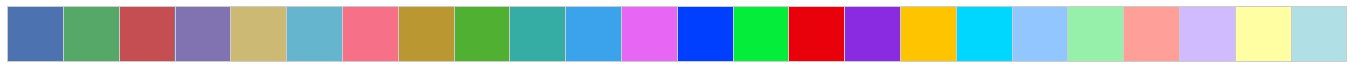

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

Считываем данные:

In [4]:
import os

# I keep data in subfolder
path_to_data = 'train.csv' if os.path.exists('train.csv') else 'data/05_train.csv'

data = pd.read_csv(path_to_data, na_values="NaN")

In [5]:
data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


Часто в соревнованиях смысл признаков не известен, в нашем соревновании это не совсем так. Вы можете посмотреть описание признаков на [странице с данными](https://www.kaggle.com/c/prudential-life-insurance-assessment/data). Резюме: значение известно только для нескольких признаков, для остальных известна только группа, к которой этот признак принадлежит (например, медицинские данные) и тип признака: вещественный, целочисленный или категориальный. При этом неясно, можно ли считать категориальные признаки упорядоченными.

Создадим три списка признаков, соответствующие их группам: вещественные, целочисленные и категориальные (эти списки даны на странице соревнования). Уберем признак Id, так как он не несет смысловой нагрузки. 

Если бы типы признаков были не даны, нам бы пришлось вручную просматривать все 128 признаков, чтобы понять, какие значения они принимают. 

In [6]:
real_features = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI", "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                 "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
discrete_features = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
cat_features = data.columns.drop(real_features).drop(discrete_features).drop(["Id", "Response"]).tolist()

### Первичный анализ

Есть набор стандартных приемов визуализации, которые нужно попробовать, когда вы начинаете работу с набором данных; к ним относятся построение гистограмм признаков (histogram, density estimation), л статистик, оценка зависимости целевого признака от остальных (boxplot, scatterplot, violinplot), визуализация пар признаков (как правило, scatterplot). Конкретный вид графика, который вам подходит, зависит от типа признаков, хороший обзор приведен в разделе Plotting functions [туториала seaborn](https://stanford.edu/~mwaskom/software/seaborn/tutorial.html).

Сначала рассмотрим числовые признаки, затем - категориальные.

##### Выведем статистики вещественных и целочисленных признаков:

In [7]:
data[real_features].describe()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59362.000000,52602.000000,48527.000000,33985.000000,30725.000000,25140.000000,40197.000000,17570.000000
mean,0.328952,0.405567,0.707283,0.292587,0.469462,0.077582,0.006283,0.361469,0.001733,0.474550,0.497737,0.444890,0.484635
std,0.282562,0.197190,0.074239,0.089037,0.122213,0.082347,0.032816,0.349551,0.007338,0.154959,0.140187,0.163012,0.129200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,0.238806,0.654545,0.225941,0.385517,0.035000,0.000000,0.060000,0.000400,0.362319,0.401961,0.323944,0.401786
50%,0.230769,0.402985,0.709091,0.288703,0.451349,0.060000,0.000000,0.250000,0.000973,0.463768,0.519608,0.422535,0.508929
75%,0.487179,0.567164,0.763636,0.345188,0.532858,0.100000,0.000000,0.550000,0.002000,0.579710,0.598039,0.563380,0.580357
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943662,1.000000


In [8]:
data[discrete_features].describe()

,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32
count,50492.000000,557.000000,14785.000000,3801.000000,1107.000000
mean,7.962172,141.118492,123.760974,50.635622,11.965673
std,13.027697,107.759559,98.516206,78.149069,38.718774
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,17.000000,1.000000,0.000000
50%,4.000000,229.000000,117.000000,8.000000,0.000000
75%,9.000000,240.000000,240.000000,64.000000,2.000000
max,240.000000,240.000000,240.000000,240.000000,240.000000


In [9]:
data.shape

(59381, 128)

In [57]:
data['Response'].describe()

count    59381.000000
mean         5.636837
std          2.456833
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max          8.000000
Name: Response, dtype: float64

__Ответьте на вопросы (Блок 1):__
* Есть ли пропуски в данных? Перечислите вещественные и целочисленные признаки, которые известны для всех объектов.
   * Ответ: Да. Только вещ-е: Product_Info_4, Ins_Age, Ht, Wt, BMI
* Перечислите вещественные и целочисленные признаки, значение которых известно менее, чем для половины объектов.
   * Ответ: вещ-е: Family_Hist_3, Family_Hist_5; целочисл-е: Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32
* Одинаков ли масштаб вещественных признаков? Масштаб целочисленных признаков? $^*$
    * Ответ: вещ-е признаки нормализованы на отрезок [0, 1] по условию, поэтому одинаков; целочисл-е не нормализованы, но масштаб их между собой одинаков.

$^*$ Будем считать, что масштаб двух признаков одинаков, если их минимумы отличаются не более, чем в 2 раза, и аналогично с максимумами.

Мы видим, что в датасете есть признаки, которые не известны почти для всех объектов. Кроме того, легко проверить, что в выборке нет объектов, для которых известны все признаки, даже если рассматривать только вещественные. Значит, при решении задачи нужно было бы использовать более сложные методы обработки пропусков, чем удаление объектов.

##### Постройте гистограммы вещественных и целочисленных признаков.
Вместо того, чтобы в цикле по признакам строить отдельно каждую гистограмму, стоит воспользоваться методом hist датафрейма. Рекомендуется отдельно вывести гистограммы вещественных и целочисленных признаков. Установите размер изображения (20, 20) для первой группы признаков и  (10, 10) для второй, bins=100.

''

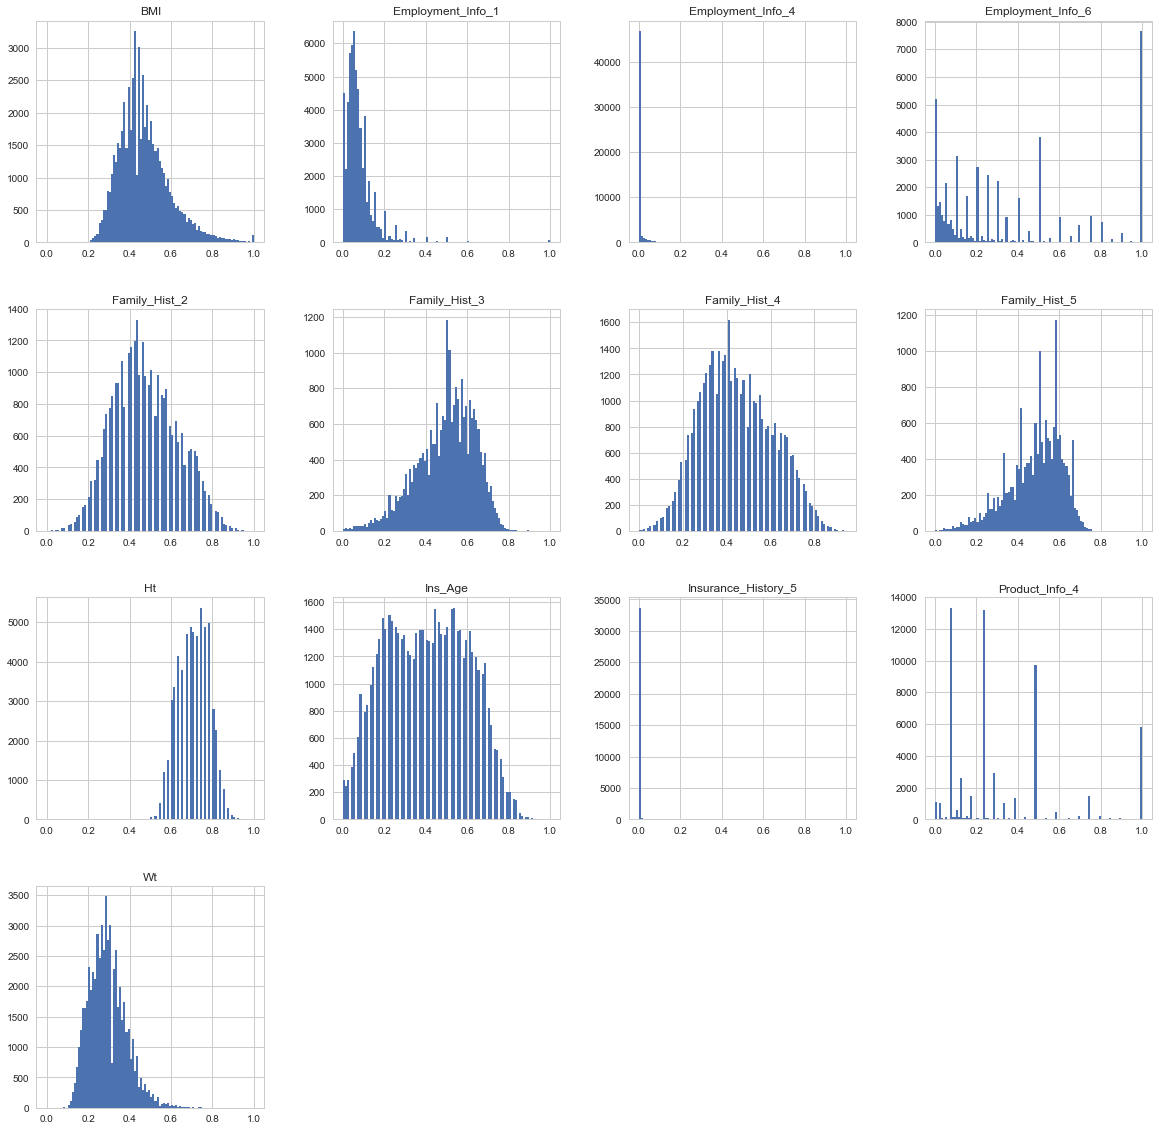

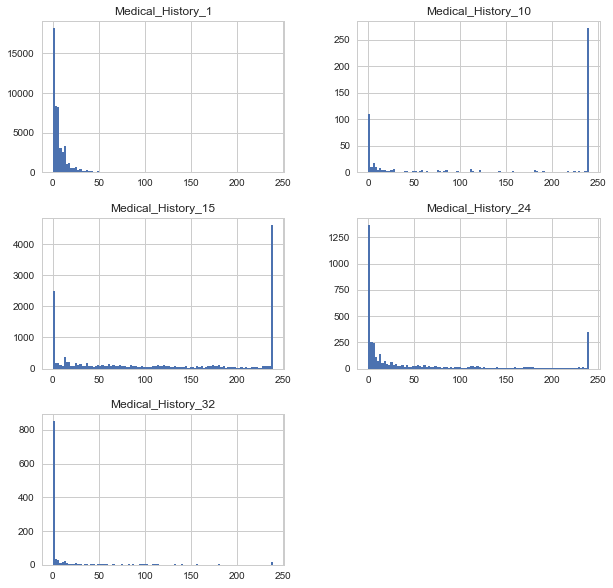

In [20]:
# Код 1. Постройте гистограммы.
data[real_features].hist(bins=100, figsize=(20,20))
data[discrete_features].hist(bins=100, figsize=(10,10))
''

__Ответьте на вопросы (Блок 2):__
* Есть ли константные признаки среди вещественных и целочисленных? Признак является константным, если множество его значений состоит из единственного элемента.
    * Ответ: строго говоря, нет. Есть два очень близких к константному, где подавляющее большинство значений попало в один bin (напр, Insurance_History_5).
* Предположим, что мы составили выборку, в которую вошли все и только вещественные признаки. Можно ли ее описать многомерным нормальным распределением? $^*$
    * Ответ: нет, часть гистограмм действительно очень похожи на гауссианы, но далеко не все - какие-то совсем не похожи, а какие-то похожи отчасти - имеют хвосты разной "тяжести" и ближе к гамма-распределению или даже распр пуассона.
    
$^*$ 
Плотность многомерного нормального распределения во всех проекциях на отдельные переменные должна быть симметрична, куполообразна, а значит, унимодальна.

Среди вещественных есть признаки с очень большим перекосом в сторону какого-то одного значения (например, Employmennt_Info_4), возможно, их стоило бы прологарифмировать при решении задачи. Кроме того, есть признаки со сложной структурой гистограммы. 
Распределения целочисленных признаков (относящихся к группе медицинских) имеют схожую структуру. 

В целом данные разнородны, и описать их одним вероятностным распределением непросто. 

##### Теперь визуализируем признаки попарно. 
Построим scatterplot для пар вещественных признаков. Для этого в seaborn есть функция pairplot. Исключим признаки, распределение которых не похоже на колокол (хотя бы скошенный и неровный), тем самым мы уменьшим размер таблицы пар. На диагоналях таблицы будут стоять оценки распределений признаков (гистограммы или восстановленные плотности, diag_kind="hist" или "kde"). Если указать параметр hue = дискретный целевой признак, то разные его значения будут отображаться разными цветами.

C:\Anaconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize)

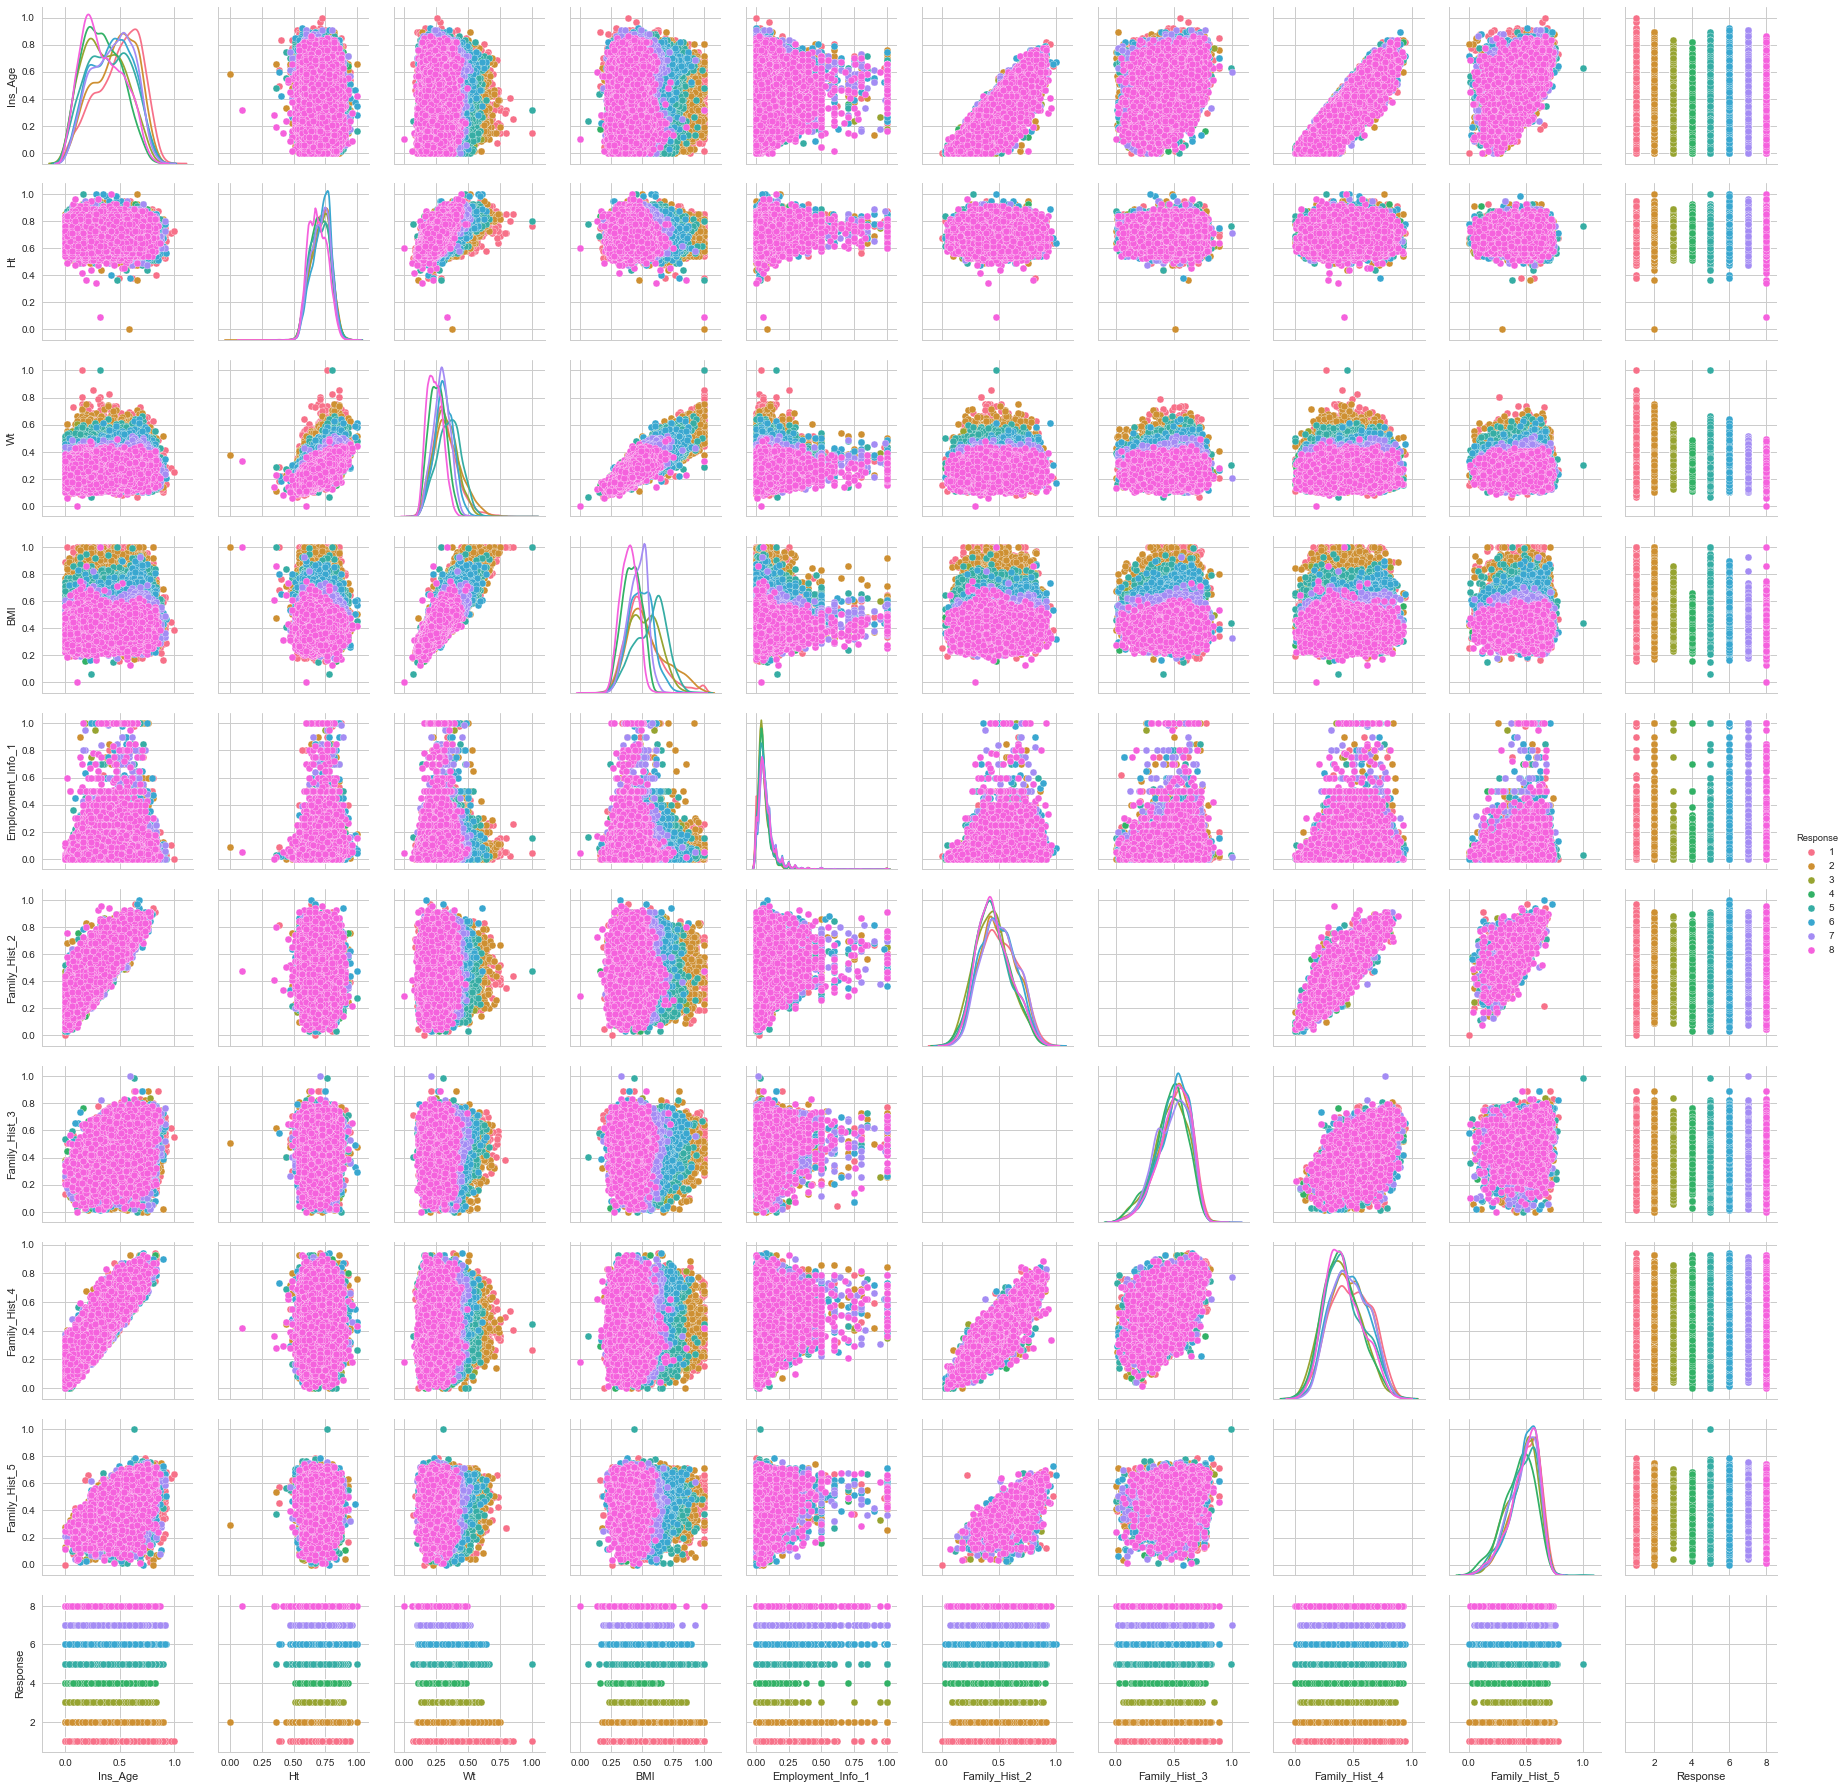

In [23]:
sns.pairplot(
    data[real_features+["Response"]].drop(
        ["Employment_Info_4", "Employment_Info_6", "Insurance_History_5", "Product_Info_4"], axis=1
    ), 
    hue="Response", diag_kind="kde"
)

Классы накрывают друг друга, и графики не очень информативны. Но они позволяют ответить на некоторые вопросы о взаимоотношениях признаков и соотношений признаков и классов.

__Ответьте на вопросы (Блок 3):__
* Есть ли пары признаков, у которых облака точек разных классов отличаются? Иными словами, есть ли графики, на которых видны облака разных классов, а не только последнего нарисованного?
    * Ответ: на всех графиках в паре с BMI или Wt видны разные классы. Ну и с Response, т.к. это и есть целевой признак.
* Есть ли объекты-выбросы, то есть такие точки, которые стоят далеко от общего облака точек?
    * Ответ: да. Например, в столбце пар с ростом (Ht) есть кто-то с ростом 0.

В целом облака точек выглядят достаточно компактно (в неформальном понимании этого слова), их можно приблизить искривленным кругом.

Теперь постройте такие же графики для целочисленных признаков (никакие признаки удалять не нужно, потому что таких признаков и так немного).

C:\Anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize)

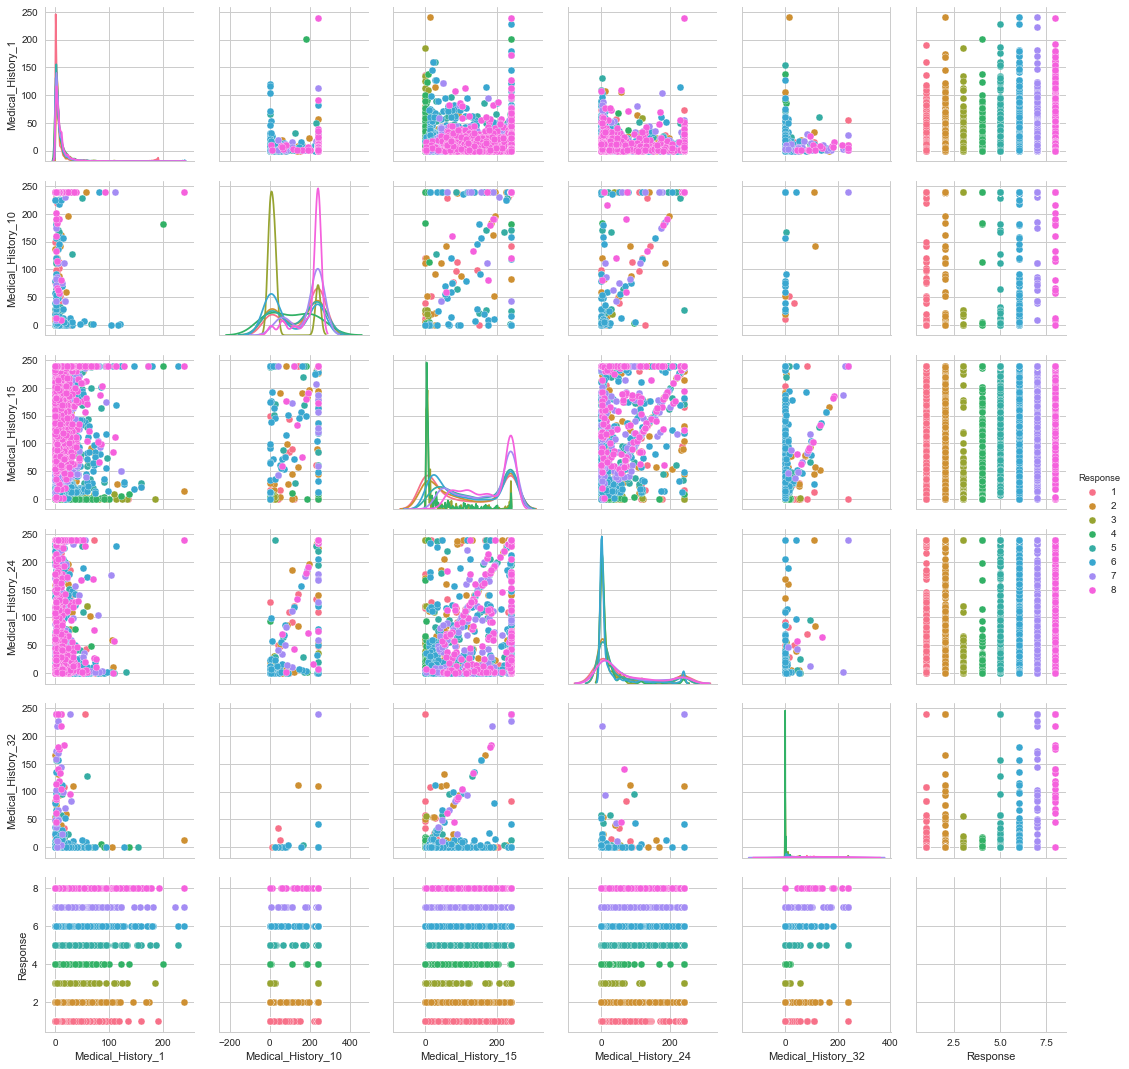

In [25]:
# Код 2. Постройте pairplot для целочисленных признаков
sns.pairplot(data[discrete_features + ['Response']], hue="Response", diag_kind="kde")

Графики выглядят еще менее информативно. Заметна тенденция, что пары признаков сконцентрированы либо на сторона квадрата [0, 240] x [0, 240], либо на его диагонали, то есть признаки как-то связаны.

##### Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед (гипотетическим) построением модели. 

Для визуализации матрицы попарных корреляций удобно использовать функцию seaborn.heatmap, она автоматически подпишет признаки на осях и покажет colorbar. Мы вычисляем корреляции только между вещественными признаками, для целочисленных признаков корреляции вычисляется по другим формулам.

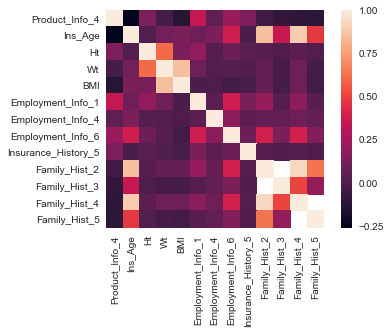

In [178]:
sns.heatmap(data[real_features].corr(), square=True)

In [179]:
corrs = data[real_features].corr().values
corrs[np.isnan(corrs)] = 0
pairs = np.argwhere(corrs > 0.9)
col_pairs = [
    (data[real_features].columns[p[0]], data[real_features].columns[p[1]])
    for p in pairs
    if p[0] < p[1]
]
col_pairs

[('Family_Hist_2', 'Family_Hist_4')]

__Ответьте на вопрос (Блок 4)__:
* Есть ли пара (несовпадающих) признаков, корреляция между которыми больше 0.9 (можно проверить программно)? Если есть, то выпишите эту пару. Напоминаем, что матрица корреляций симметрична, и дважды выписывать одну пару признаков не нужно.
    * Ответ: ('Family_Hist_2', 'Family_Hist_4')

Перейдем к визуализации категориальных признаков.

##### Посчитаем количество значений для каждого признака.
Строим много графиков вручную (а не с помощью готовой функции, как с hist или pairplot). Для этого создаем новую pyplot-фигуру, указываем, сколько графиков на ней будет, задаем размер; параметр sharey говорит не подписывать все оси отдельно, а подписать их только один раз слева; здесь это уместно, потому что масштабы всех счетчиков одни и те же. 

В цикле по всем категориальным признакам строим countplot признака с помощью seaborn. Указываем параметр data, какой признак визуализировать, а также передаем ссылку на конкретную ячейку таблицы, в которой нужно изобразить график. Признаков всего 108, поэтому последние две ячейки таблицы графиков размером 11 x 10 останутся пустыми.

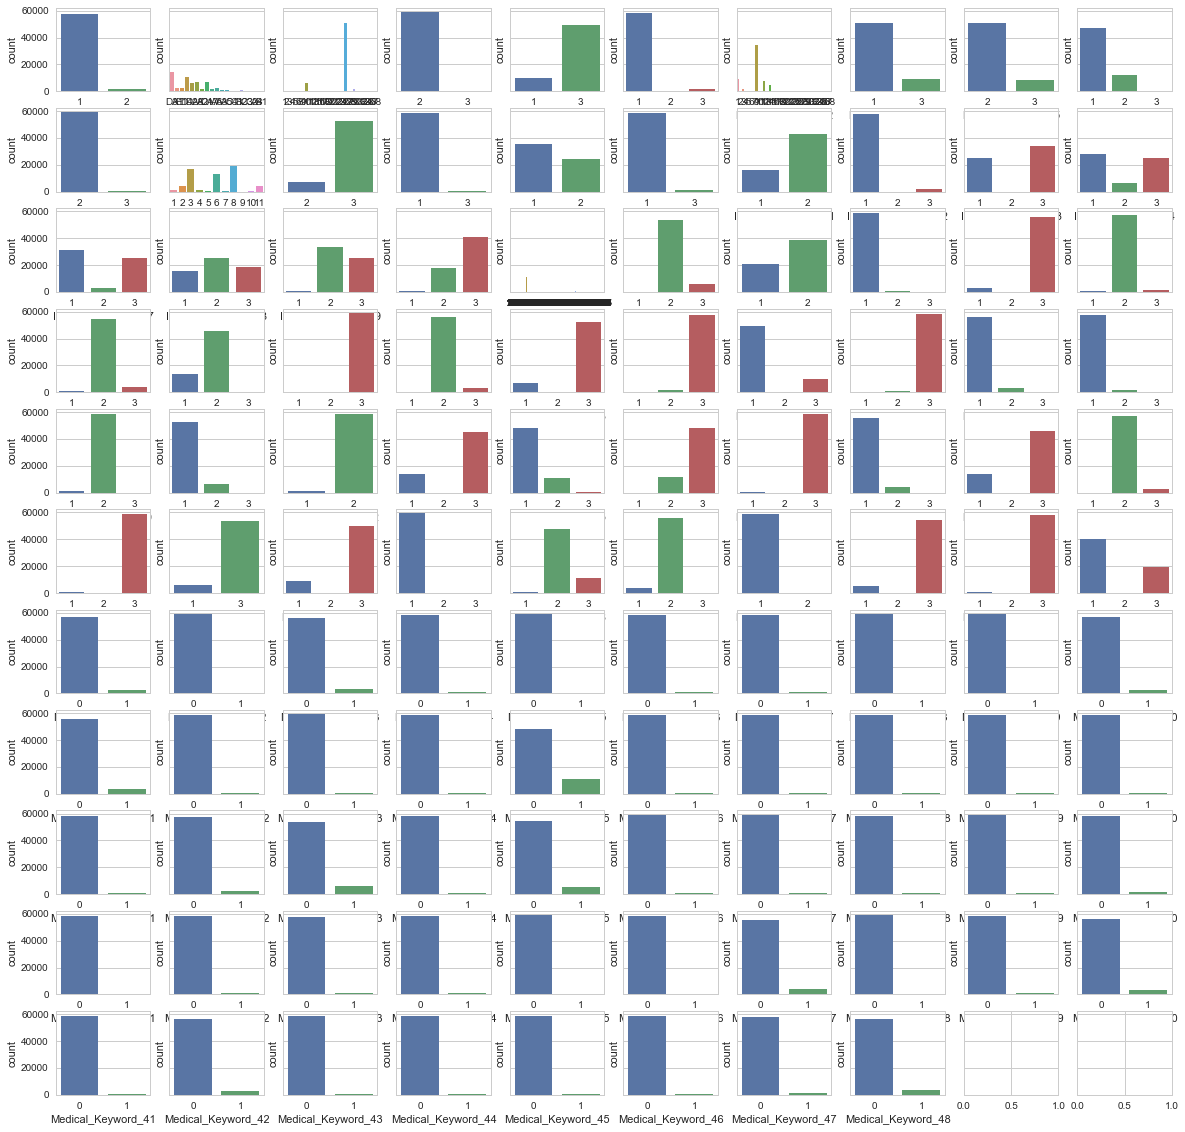

In [44]:
fig, axes = plt.subplots(11, 10, figsize=(20, 20), sharey=True)
for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data=data, ax=axes[i // 10, i % 10])

__Ответьте на вопросы (Блок 5)__:
* Есть ли среди категориальных признаков константные?
    * Ответ: нет, как минимум два значения у каждого.
* Есть ли признаки с количеством возможных категорий (число значений признака) больше 5?
    * Ответ: да, напр, 2й, 7й, 12й графики.

У нас есть много признаков с сильными перекосами в сторону отдельного признака. Учитывая, что среди категориальных признаков много медицинских показателей, можно предположить, что именно эти признаки сильно влияют на увеличение риска (целевой признак). Проверить это предположение можно, построив такие же countplot с разбивкой каждого значения дополнительно по классам (то есть у нас будет несколько групп столбиков, и в каждой группе их будет 8). Это можно сделать, указав параметр hue в этой функции аналогично тому, как мы это делали выше.

Постройте графики countplot для признаков 'Medical_Keyword_23', 'Medical_Keyword_39', 'Medical_Keyword_45' (признаки выбраны случайно) с разбивкой по классам.

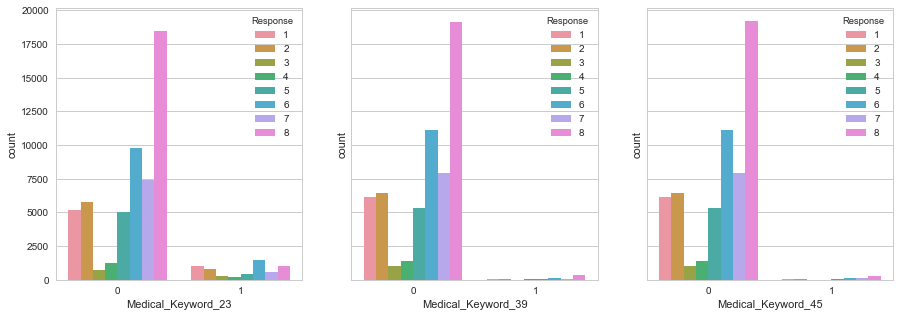

In [56]:
# Код 3. Постройте countplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
subset_features = ['Medical_Keyword_23', 'Medical_Keyword_39', 'Medical_Keyword_45']

for i in range(len(subset_features)):
    sns.countplot(x=subset_features[i], data=data, ax=axes[i], hue='Response')

__Ответьте на вопрос (Блок 6)__:
* Наличие каких из этих трех факторов сильно повышает риск? Будем считать, что наличие признака сильно повышает риск, если количество человек, имеющих этот признак (то есть он для них равен 1) и отнесенных к категории риска 8, больше, чем такая же величина для любой другой категории риска.
    * Ответ: для \_39 и \_45. Конечно, учитывая, общее распределение целевого признака, говорить о сильном повышении риска не совсем логично - отсутствие всех трех выбранных признаков, судя по графику, тоже "сильно повышает риск" :)

##### Наконец, посмотрим на распределение целевого признака, чтобы узнать, сбалансированы ли классы:

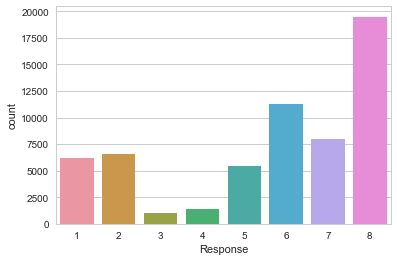

In [59]:
sns.countplot(data.Response)

В категорию 8 люди попадают чаще, чем в другие категории.

### Визуализация с помощью понижения размерности

Далее можно воспользоваться средствами понижения размерности. Для задачи с дискретным целевым признаком это позволит понять, какие классы хорошо разделяются, а какие - нет.

Такие методы строят матрицу попарных расстояний между объектами, которая в случае, когда объектов много, будет занимать много памяти. Кроме того, отображать много точек на scatter plot (а именно его используют для визуализации результата понижения размерности) неудобно. Поэтому мы перемешаем выборку (и далее будем использовать ее) и выберем первые 1000 объектов для понижения размерности. Вы можете попробовать взять больше объектов.

In [60]:
from sklearn.utils import shuffle
from sklearn.preprocessing import scale

In [61]:
sdata = shuffle(data, random_state=321)
# del data   # удалите неперемешанные данные, если не хватает оперативной памяти

Методы sklearn не принимают матрицы с пропусками (nan). Чтобы избежать этой проблемы, не будем рассматривать признаки, которые имеют много пропусков (последние четыре в списке вещественных признаков). Кроме того, ограничимся рассмотрением вещественных признаков.

В следующей ячейке мы отбираем нужные признаки, затем находим объекты, у которых все признаки известны (нет пропусков в выбранных признаках), а затем создаем отдельно матрицу объекты-признаки для работы методов понижения размерности и отдельно вектор правильных ответов на этих объектах: data_subset и response_subset. Кроме того, мы дополнительно стандартизуем нашу маленькую выборку, потому что методы понижения размерности очень чувствительны к разномасштабным данным (это отдельно указано в [туториале](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) в sklearn)

In [62]:
subset_l  = 1000
selected_features = real_features[:-4]
objects_with_nan = sdata.index[np.any(np.isnan(sdata[selected_features].values), axis=1)]
data_subset = scale(sdata[selected_features].drop(objects_with_nan, axis=0)[:subset_l])
response_subset = sdata["Response"].drop(objects_with_nan, axis=0)[:subset_l]

Будем строить визуализацию методами, разобранными на лекции: t-SNE и MDS.

In [63]:
from sklearn.manifold import TSNE
# import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

Методы понижения размерности имеют такой же интерфейс, как классификаторы и регрессоры. Для построения визуализации t-SNE нужно создать объект класса и вызвать его метод fit_transform, который вернет матрицу размера число объектов x новая размерность; по умолчанию новая размерность равна 2. Выполните эти действия и запишите результат работы метода в переменную tsne_representation. Рекомендуем ознакомиться с параметрами метода на [странице документации TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE). <font color="red"> Зафиксируйте случайное приближение random_state=321, чтобы результат визуализации у всех был одинаковый. </font> 

In [180]:
# Код 4. Присвойте переменной tsne_representation результат понижения размерности методом tSNE с параметрами по умолчанию
tsne = TSNE(n_components=2, random_state=321)
tsne_representation = tsne.fit_transform(data_subset)

Визуализируем полученное представление. Для этого создадим набор цветов по количеству классов, а затем в цикле по классам будем отображать представления точек, относящихся к этому классу. Будем указывать параметр alpha=0.5, чтобы сделать точки полупрозрачными, это лучше в ситуации, когда точки накладываются.

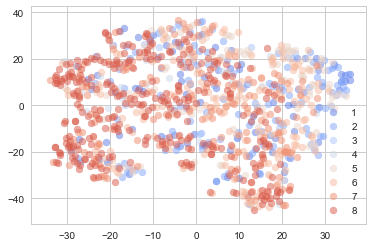

In [181]:
# colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
colors = sns.color_palette("coolwarm", 8).as_hex()

for y, c in zip(set(data.Response), colors):
    plt.scatter(tsne_representation[response_subset.values==y, 0], 
                tsne_representation[response_subset.values==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()

Теперь сделаем то же с MDS.

In [72]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances

In [75]:
# Код 5. Присвойте переменной MDS_transformed результат понижения размерности методом MDS с параметрами по умолчанию
# Не забудьте зафиксировать random_state=321

mds = MDS(n_components=2, random_state=321)
MDS_transformed = mds.fit_transform(data_subset)

(-5, 5)

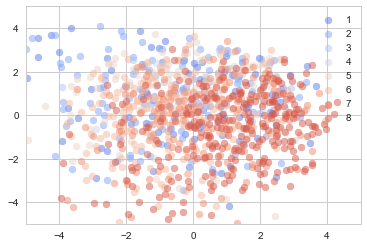

In [97]:
colors = sns.color_palette("coolwarm", 8).as_hex()

for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed[response_subset.values==y, 0], 
                MDS_transformed[response_subset.values==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()
plt.xlim(-5, 5)   # масса точек концентрируется в этом масштабе
plt.ylim(-5, 5)   # рекомендуем сначала отобразить визуализацию целиком, а затем раскомментировать эти строки.

Для построения представления можно пробовать разные метрики, их список доступен в [документации scipy](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html) (потому что sklearn использует метрики scipy). Вы можете попробовать использовать разные метрики в t-SNE и MDS и смотреть получающиеся визуализации, по мнению автора задания наиболее информативной выглядит визуализация MDS c косинусной метрикой ("cosine"). 

В t-SNE метрику можно указать при создании объекта класса TSNE, в MDS это реализуется несколько сложнее. Нужно указать dissimilarity="precomputed", а в fit_transform подать не матрицу объектов, а матрицу попарных расстояний между объектами. Создать ее можно с помощью функции pairwise_distances с параметрами: матрица объектов, метрика.

In [80]:
# Код 6. Присвойте переменной MDS_transformed_cos результат понижения размерности методом MDS с косинусной метрикой
mds_cos = MDS(n_components=2, random_state=321, dissimilarity='precomputed')
pairwise_dists = pairwise_distances(data_subset, metric='cosine')

MDS_transformed_cos = mds_cos.fit_transform(pairwise_dists)

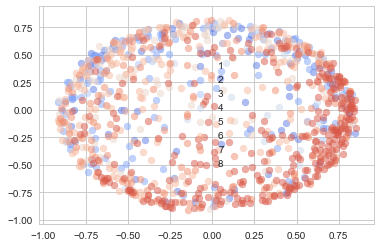

In [93]:
colors = sns.color_palette("coolwarm", 8).as_hex()

for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed_cos[response_subset.values[:subset_l]==y, 0], 
                MDS_transformed_cos[response_subset.values[:subset_l]==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()

__Ответьте на вопросы (Блок 7):__ Будем нумеровать визуализации от 1 до 3: tSNE, MDS по умолчанию, MDS с косинусной метрикой.
* Есть ли визуализация, на которой классы хорошо разделяются? Классы хорошо разделяются, если между облаками точек разных классов можно проводить границы. Если есть, укажите хотя бы одну такую визуализацию.
    * Ответ: Нет
* Есть ли визуализации, по которым видно, что объекты с наименьшим риском (1 и 2) отличаются от объектов с высоким риском (7 и 8)? Будем считать, что объекты классов A и B отличаются, если можно выделить область плоскости, в которой в целом больше точек класса A, и можно выделить область, в которой больше точек класса B. Если есть, укажите хотя бы одну такую визуализацию.
    * Ответ: Больше всего заметно на 2ом. С некоторыми оговорками и желанием найти, эти области можно выделить на всех трех визуализациях:
        * tSNE - справа сверху есть небольшая область выраженного низкого риска, а в левой половине и снизу крайний кусочек - там преобладает высокий риск
        * MDS default - слева сверху область низкого риска, в правой половине - область высокого риска
        * MDS cosine - часть на границе эллипса, находящаяся ниже графика y=x имеет ярко-выраженный высокий риск, а в левом верхнем углу концентрация низкорисковых точек увеличивается, но не доминирует.
* Есть ли визуализации, на которым видны отдельно стоящие (от общего облака) точки? Если есть, укажите хотя бы одну такую визуализацию.
    * Ответ: да, на 2м графике, если закомментировать явное указание границ графика, то будут видны точки, похожие на выбросы

Визуализации разными методами достаточно сильно отличаются, но на каждой можно условно выделить направление, вдоль которого происходит увеличение риска от 1 до 8 (то есть точки постепенно меняют цвет). Если бы это не выполнялось, можно было бы предположить, что задача не решаема.

### Поиск аномалий

Воспользуемся методами поиска аномалий, рассмотренными в лекции.

##### One class SVM
Для простоты выберем вещественные признаки, которые известны для всех объектов: Product_Info_4, Ins_Age, Ht, Wt, BMI. Оставим только те, которые относятся к человеку, то есть не будем рассматривать Product_Info_4. Получится, что мы отбираем нестандартных по комбинации вес/рост/возраст людей.

In [143]:
from sklearn import svm

In [144]:
person_features = ["Ins_Age", "Ht", "Wt", "BMI"]

Два ключевых параметра OC_SVM - gamma и nu. Первый влияет на то, как хорошо граница будет приближать данные, второй - сколько точек нужно относить к выбросам. Вы можете попробовать разные значения, в том числе, значения по умолчанию, и убедиться, что при них алгоритм работает не очень адекватно. Запустите следующую ячейку, на ее выполнение может понадобиться некоторое время.

In [145]:
svm_ = svm.OneClassSVM(gamma=10, nu=0.01)
svm_.fit(sdata[person_features])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [146]:
labels = svm_.predict(sdata[person_features])

In [147]:
(labels==1).mean()

0.9899631195163436

У вас должно получиться, что около 98% объектов не признаются выбросами. 

Попытаемся визуализировать, какие объекты отнесены к шумовым. Для этого нужно построить scatter-графики для каждой пары признаков в person_features (всего 6 графиков). На каждом графике нужно отдельно отобразить точки с labels==1 и labels==-1. 

Создайте pyplot-фигуру с 6 графиками: 2 x 3, укажите размер фигуры (12, 8). Затем в цикле по __парам признаков__ из person_features отобразите scatter-графики точек (сделайте точки с разными labels разных цветов: синие, c="blue", - обычные точки, у которых labels==1, красные, c="red",  - шумовые, у которых labels==-1.) Для построения графика можно пользоваться командой axes[...].scatter(...), вместо ... - ваш код. Функция scatter принимает две вектора одинаковой длины, абсциссы и ординаты точек, и дополнительные параметры, например, цвет c и коэффициент прозрачности точек alpha. Подпишите оси названиями признаков, это можно сделать с помощью команды axes[...].set_xlabel(...) или axes[...].ylabel(...).

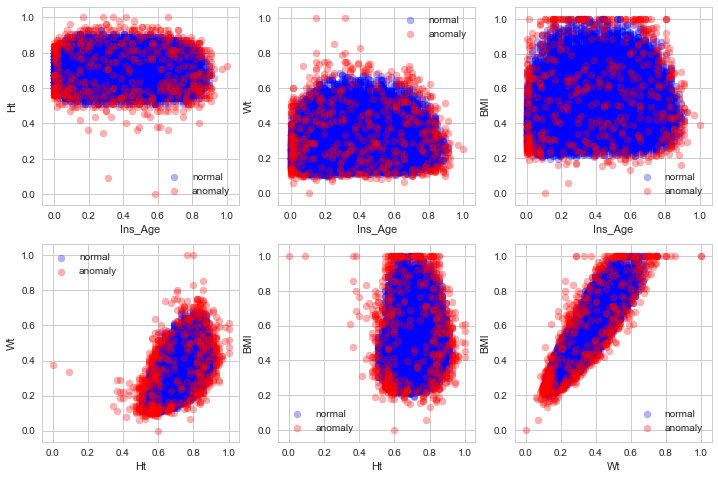

In [183]:
# Код 7. Постройте 6 графиков
feature_pairs = [
    (fx, fy)
    for i, fx in enumerate(person_features)
    for j, fy in enumerate(person_features)
    if i < j
]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, p in enumerate(feature_pairs):
    ax = axes[i // 3, i % 3]
    ax.scatter(sdata.loc[labels == 1, p[0]], sdata.loc[labels == 1, p[1]], c='b', alpha=0.3, label='normal')
    ax.scatter(sdata.loc[labels == -1, p[0]], sdata.loc[labels == -1, p[1]], c='r', alpha=0.3, label='anomaly')
    ax.set_xlabel(p[0])
    ax.set_ylabel(p[1])
    ax.legend()


Вы должны увидеть, что, во-первых, облака синие точки заполняют почти все облако точек, а во-вторых, красные точки находятся на границе или далеко от облака (интуитивно понятно, что это аномальные объекты). 

##### Непараметрическое восстановление плотности.
Искать аномалии можно, анализируя непараметрически восстановленную плотность одномерного распределения. Так можно заметить, что какие-то объекты выбиваются из общей тенденции. 

В seaborn это удобно делать с помощью метода distplot. Посмотрев на гистограммы в начале ноутбука, выберем для ближайшего рассмотрения признаки BMI, Employment_Info_1, Medical_History_32. 

Примените метод distplot к этим трем признакам, указав bins=50. Рекомендуется удалять значения nan с помощью метода датафрейма .dropna().

C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been repl

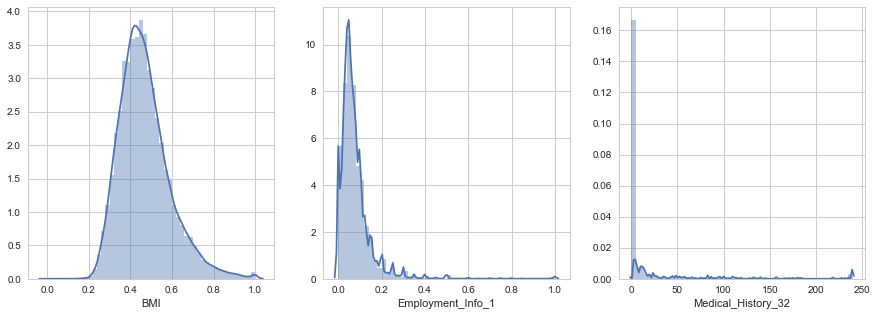

In [167]:
# Код 8. Восстановите плотности трех для трех указанных признаков
cols = ['BMI', 'Employment_Info_1', 'Medical_History_32']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(cols):
    sample_data = data[col].dropna()
    sns.distplot(sample_data, bins=50, ax=axes[i])

На трех графиках видно, что в конце множества значений признака есть скачок, и это явление очень похоже на аномалию.

### Заключение
Мы познакомились с методами визуализации и отбора шумовых объектов и посмотрели на примере, с чего стоит начинать работу с новым датасетом. Как и в других методах анализа данных, в методах визуализации приходится подбирать параметры, но здесь эта задача осложняется отсутствием автоматически вычисляемого критерия качества визуализации, и подбирать параметры приходится вручную.